In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using CSV, DataFrames
# Creamos un data frame a partir del archivo CSV.
df = CSV.read(download("https://aprendeconalf.es/aprendizaje-automatico-practicas-julia/datos/viviendas.csv"), DataFrame)
# Mostramos las primeras cinco filas del data frame.
first(df, 5)

Row,precio,area,dormitorios,baños,habitaciones,calleprincipal,huespedes,sotano,calentador,climatizacion,garaje,centrico,amueblado
,Int64,Int64,Int64,Int64,Int64,String3,String3,String3,String3,String3,Int64,String3,String15
1,13300000,7420,4,2,3,si,no,no,no,si,2,si,amueblado
2,12250000,8960,4,4,4,si,no,no,no,si,3,no,amueblado
3,12250000,9960,3,2,2,si,no,si,no,no,2,si,semi-amueblado
4,12215000,7500,4,2,2,si,no,si,no,si,3,si,amueblado
5,11410000,7420,4,1,2,si,si,si,no,si,2,no,amueblado


In [3]:
# Extraemos las columnas area y precio.
X = Float32.(df.area)
y = Float32.(df.precio) ./ 1000

545-element Vector{Float32}:
 13300.0
 12250.0
 12250.0
 12215.0
 11410.0
 10850.0
 10150.0
 10150.0
  9870.0
  9800.0
  9800.0
  9681.0
  9310.0
     ⋮
  2100.0
  2100.0
  2100.0
  1960.0
  1890.0
  1890.0
  1855.0
  1820.0
  1767.15
  1750.0
  1750.0
  1750.0

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/ux0Te/src/scenes.jl:238


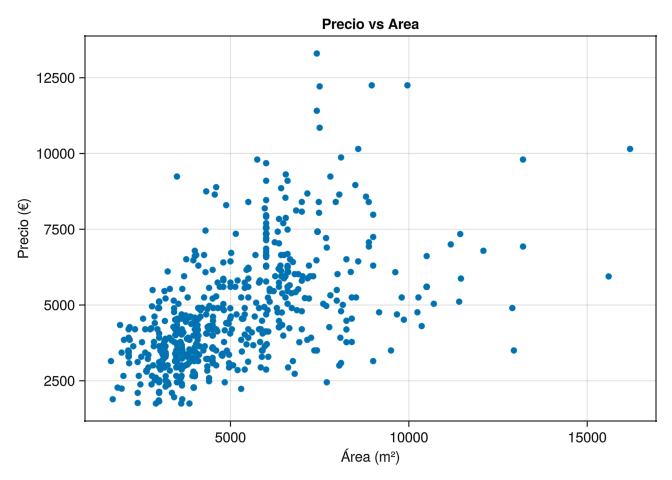

In [4]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], title = "Precio vs Area", xlabel = "Área (m²)", ylabel = "Precio (€)")
scatter!(ax, X, y)
fig

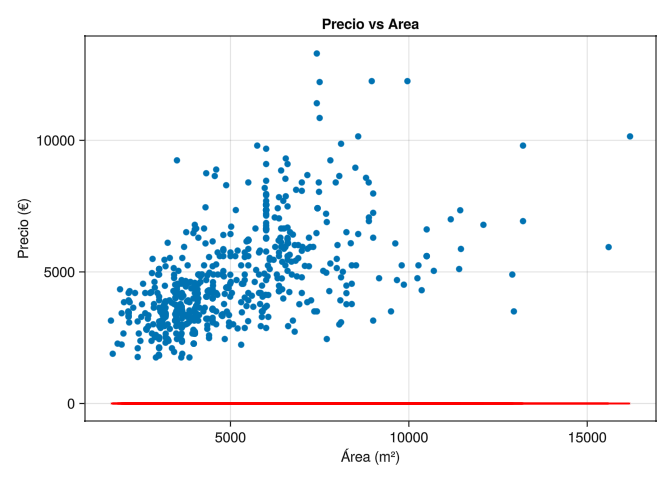

In [5]:
# Definimos el modelo lineal.
perceptron(W, b, x) = @. W[1] * x + b[1]
# Inicializamos los pesos y el término independiente.
W = Float32[0]
b = Float32[0]
lines!(ax, X, perceptron(W, b, X), label = "Modelo 0", color = :red)
fig

In [6]:
using Statistics
# Definimos la función de coste.
coste(W, b, X, y) = mean((y .- perceptron(W, b, X)).^2)
# Calculamos el coste del modelo inicial.
println("Error cuadrático medio: ", coste(W, b, X, y))

Error cuadrático medio: 2.6213836e7


Gradiente del coste: (Float32[-5.344584f7], Float32[-9533.46])


Parámetros iniciales: W = Float32[0.0], b = Float32[0.0]
Nuevos parámetros: W = [0.5344584], b = [9.5334599609375e-5]
Error cuadrático medio: 6.569670916877353e6

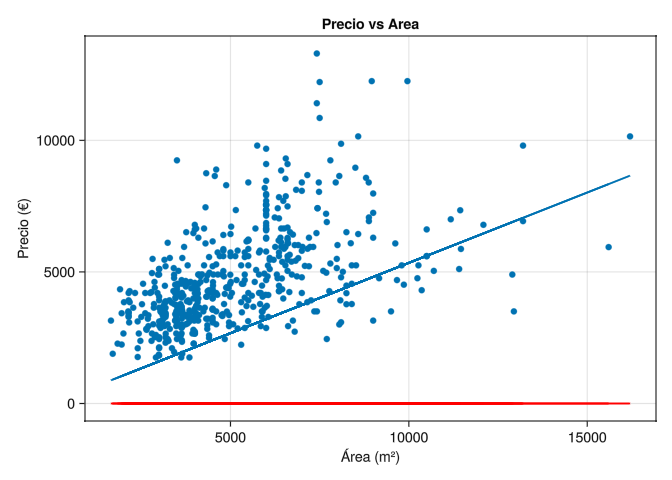

In [7]:
using Flux
# Declaramos los pesos como variables simbólicas

# Calculamos el gradiente del coste.
∂E_∂W, ∂E_∂b = gradient(coste, W, b, X, y)
# Mostramos el gradiente.
println("Gradiente del coste: ($∂E_∂W, $∂E_∂b)")
# Definimos la tasa de aprendizaje.
η = 1e-8
# Mostramos los parámetros iniciales.
println("Parámetros iniciales: W = $W, b = $b")
# Actualizamos los parámetros en la dirección de
W -= η * ∂E_∂W
b -= η * ∂E_∂b
# Mostramos los nuevos parámetros.
println("Nuevos parámetros: W = $W, b = $b")
# Comprobamos que el error cuadrático medio ha disminuido.
println("Error cuadrático medio: ", coste(W, b, X, y))
# Dibujamos el nuevo modelo en el diagrama de dispersión.
lines!(ax, X, perceptron(W, b, X), label = "Modelo 1")
fig

In [8]:
function entrenar_perceptron!(W, b, X, y, η)
    """
    Función para entrenar el perceptrón.
    W: peso del modelo.
    b: término independiente del modelo.
    X: vector de entradas.
    y: vector de salidas.
    η: tasa de aprendizaje.
    """
    # Calculamos el gradiente del coste.
    ∂E_∂W, ∂E_∂b = gradient(coste, W, b, X, y)
    # Actualizamos los parámetros en la dirección opuesta al gradiente.
    W .-= η * ∂E_∂W
    b .-= η * ∂E_∂b
end

entrenar_perceptron! (generic function with 1 method)

Iteración 2

, Parámetros: W = [0.7351053379977437], b = [0.00013561418157921425], Coste: 3.8010036630367776e6
Iteración 3, Parámetros: W = [0.8104324229132014], b = [0.0001552249559885306], Coste: 3.4107850089995693e6
Iteración 4, Parámetros: W = [0.838711796053412], b = [0.00016707622479181458], Coste: 3.355787208775712e6
Iteración 5, Parámetros: W = [0.8493284674839952], b = [0.00017601441178095897], Coste: 3.348035761002203e6
Iteración 6, Parámetros: W = [0.8533141887596891], b = [0.00018385896650121626], Coste: 3.3469432599931033e6
Iteración 7, Parámetros: W = [0.8548105117157216], b = [0.00019129294862501068], Coste: 3.34678927740313e6
Iteración 8, Parámetros: W = [0.8553722621219417], b = [0.00019857279313692855], Coste: 3.3467675705099306e6
Iteración 9, Parámetros: W = [0.855583154313161], b = [0.00020579477113007419], Coste: 3.3467645066817994e6
Iteración 10, Parámetros: W = [0.855662326942257], b = [0.00021299502480003158], Coste: 3.3467640704253544e6


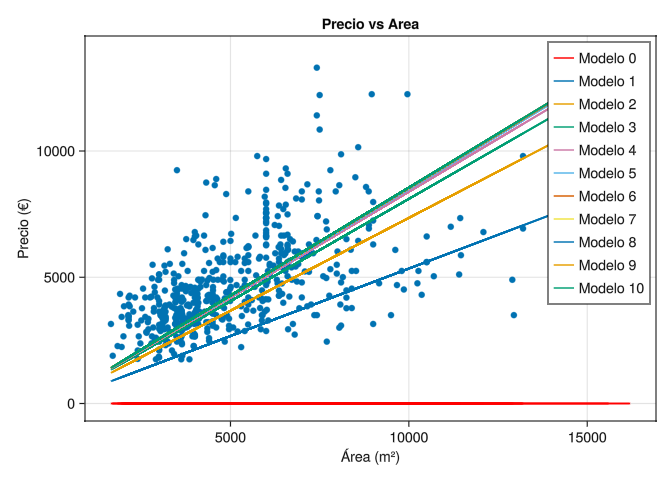

In [9]:
# Repetimos el proceso de entrenamiento del perceptrón.
for i = 2:10
    entrenar_perceptron!(W, b, X, y, η)
    # Mostramos los parámetros y el coste del modelo.
    ecm = coste(W, b, X, y)
    println("Iteración ", i, ", Parámetros: W = $W, b = $b, Coste: $ecm")
    # Dibujamos el modelo actualizado en el diagrama de dispersión.
    lines!(ax, X, perceptron(W, b, X), label = "Modelo $i")
end
axislegend(ax)
fig

In [10]:
# Definimos una capa con una sola neurona con una entrada.
modelo = Dense(1 => 1)
# Mostramos los parámetros del modelo.
println("Pesos: ", modelo.weight, ", Término independiente: ", modelo.bias)

Pesos: Float32

[0.8322743;;], Término independiente: Float32

[0.0]


In [11]:
# Convertimos el vector de las areas en una matriz de una sola fila.
X = reshape(X, 1, length(X))
ŷ = modelo(X)

1×545 Matrix{Float32}:
 6175.48  7457.18  8289.45  6242.06  …  1997.46  3012.83  2421.92  3204.26

In [12]:
# Convertimos el vector de los precios en una matriz de una sola columna.
y = reshape(y, 1, length(y))
# Definimos la función de coste como el error cuadrático medio.
coste(modelo, X, y) = Flux.mse(modelo(X),y)
coste(modelo, X, y)

3.3639158f6

Número de iteraciones: 3


Coste final: 3.3468115e6


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/ux0Te/src/scenes.jl:238


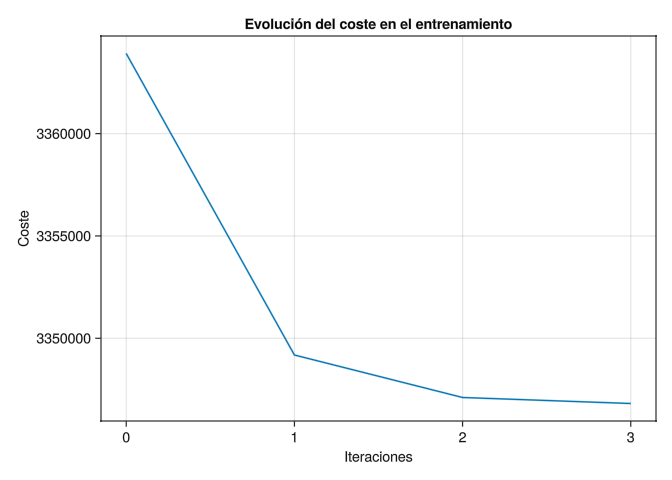

In [13]:
function entrenar_modelo!(modelo, coste, X, y, η)
    """
    Función para entrenar el modelo.
    modelo: modelo a entrenar.
    coste: función de coste.
    X: matriz de entradas.
    y: matriz de salidas.
    η: tasa de aprendizaje.
    """
    # Calculamos el gradiente del coste.
    ∇ = gradient(coste, modelo, X, y)
    # Actualizamos los parámetros del modelo en la dirección opuesta al gradiente.
    @. modelo.weight = modelo.weight - η * ∇[1].weight
    @. modelo.bias = modelo.bias - η * ∇[1].bias
end
# Creamos un vector para guardar los costes del proceso de entrenamiento.
costes = [coste(modelo, X, y)]
reduccion_coste = Inf
iteraciones = 0
# Iteramos el proceso de aprendizaje hasta que la reducción del coste sea menor del 0.01%.
while reduccion_coste > 0.0001
    iteraciones += 1
    entrenar_modelo!(modelo, coste, X, y, η)
    # Calculamos el nuevo coste y lo añadimos al vector de costes.
    push!(costes, coste(modelo, X, y))
    # Calculamos la reducción del coste.
    reduccion_coste = abs((costes[end] - costes[end-1]) / costes[end])
end
# Mostramos el número de iteraciones y el coste final.
println("Número de iteraciones: ", iteraciones)
println("Coste final: ", costes[end])
# Dibujamos el coste en cada iteración.
fig2 = Figure()
ax2 = Axis(fig2[1, 1], title = "Evolución del coste en el entrenamiento", xlabel = "Iteraciones", ylabel = "Coste")
lines!(ax2, 0:iteraciones, costes)
fig2

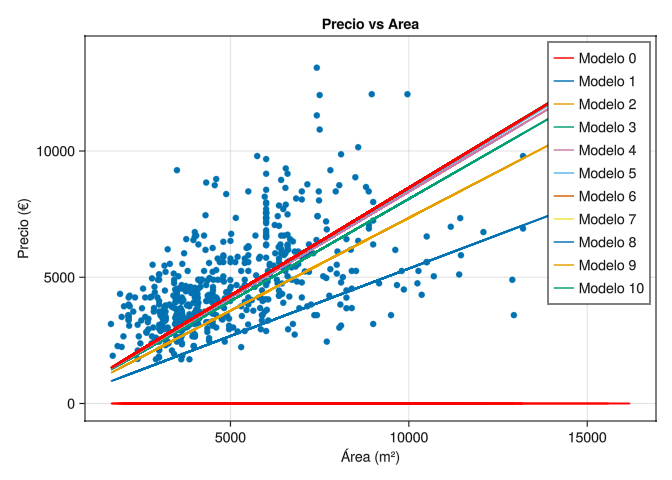

In [14]:
# Dibujamos el modelo final en el diagrama de dispersión.
lines!(ax, vec(X), vec(modelo(X)), label = "Modelo final", color = :red, linewidth = 2)
fig

In [15]:
# Definimos el modelo con 12 entradas y 1 salida.
modelo = Dense(12 => 1)
# Mostramos los parámetros del modelo.
println("Pesos: ", modelo.weight, ", Término independiente: ", modelo.bias)

Pesos: Float32[-0.33077675 0.475148 0.45860797 -0.65326595 -0.3067425 0.46475366 -0.4920061 0.33808297 0.2910382 -0.040311083 -0.041551717 0.27110094], Término independiente: Float32[0.0]


In [16]:
using MLJ
# Extraemos las etiquetas.
y = Float32.(df.precio / 1000)
# Extraemos las características de entrada.
X = select(df, Not(:precio))
# Convertimos las columnas cualitativas en cuantitativas.
schema(X)

┌────────────────┬──────────┬──────────┐
│ names          │ scitypes │ types    │
├────────────────┼──────────┼──────────┤
│ area           │ Count    │ Int64    │
│ dormitorios    │ Count    │ Int64    │
│ baños          │ Count    │ Int64    │
│ habitaciones   │ Count    │ Int64    │
│ calleprincipal │ Textual  │ String3  │
│ huespedes      │ Textual  │ String3  │
│ sotano         │ Textual  │ String3  │
│ calentador     │ Textual  │ String3  │
│ climatizacion  │ Textual  │ String3  │
│ garaje         │ Count    │ Int64    │
│ centrico       │ Textual  │ String3  │
│ amueblado      │ Textual  │ String15 │
└────────────────┴──────────┴──────────┘


In [17]:
# Convertimos las columnas de tipo texto a tipo categórico.
coerce!(X, Textual => Multiclass)
# Convertimos las columnas categóricas a tipo numérico.
coerce!(X, Multiclass => Count)
# Convertimos las columnas de tipo Int64 a tipo Int32 para ganar eficiencia.
X = Float32.(X)
# Observamos el nuevo esquema del data frame.
schema(X)

┌────────────────┬────────────┬─────────┐
│ names          │ scitypes   │ types   │
├────────────────┼────────────┼─────────┤
│ area           │ Continuous │ Float32 │
│ dormitorios    │ Continuous │ Float32 │
│ baños          │ Continuous │ Float32 │
│ habitaciones   │ Continuous │ Float32 │
│ calleprincipal │ Continuous │ Float32 │
│ huespedes      │ Continuous │ Float32 │
│ sotano         │ Continuous │ Float32 │
│ calentador     │ Continuous │ Float32 │
│ climatizacion  │ Continuous │ Float32 │
│ garaje         │ Continuous │ Float32 │
│ centrico       │ Continuous │ Float32 │
│ amueblado      │ Continuous │ Float32 │
└────────────────┴────────────┴─────────┘


In [18]:
# Convertimos el data frame a una matriz y la transponemos.
X = Matrix(X)'
X = Flux.normalise(X)
y = y'
# Definimos como función de coste el error cuadrático medio.
coste(modelo, X, y) = Flux.mse(modelo(X), y)
# Calculamos el coste del modelo inicial.
println("Error cuadrático medio: ", coste(modelo, X, y))

Error cuadrático medio: 2.621381e7

In [19]:
function entrenar_modelo!(modelo, coste, X, y, η)
    """
    Función para entrenar el modelo.
    modelo: modelo a entrenar.
    coste: función de coste.
    X: matriz de entradas.
    y: matriz de salidas.
    η: tasa de aprendizaje.
    """
    # Calculamos el gradiente del coste.
    ∇ = gradient(coste, modelo, X, y)
    # Actualizamos los parámetros del modelo en la dirección opuesta al gradiente.
    @. modelo.weight = modelo.weight - η * ∇[1].weight
    @. modelo.bias = modelo.bias - η * ∇[1].bias
end
# Definimos la tasa de aprendizaje.
η = 1e-2
# Creamos un vector para guardar los costes del proceso de entrenamiento.
costes = [coste(modelo, X, y)]
reduccion_coste = Inf
iteraciones = 0
# Iteramos el proceso de aprendizaje hasta que la reducción del coste sea menor del 0.01%.
while reduccion_coste > 1e-4
    iteraciones += 1
    entrenar_modelo!(modelo, coste, X, y, η)
    # Calculamos el nuevo coste y lo añadimos al vector de costes.
    push!(costes, coste(modelo, X, y))
    # Calculamos la reducción del coste.
    reduccion_coste = abs((costes[end] - costes[end-1]))
end
# Mostramos el número de iteraciones y el coste final.
println("Número de iteraciones: ", iteraciones)
println("Coste final: ", costes[end])

Número de iteraciones: 413


Coste final: 1.1411414e6


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/ux0Te/src/scenes.jl:238


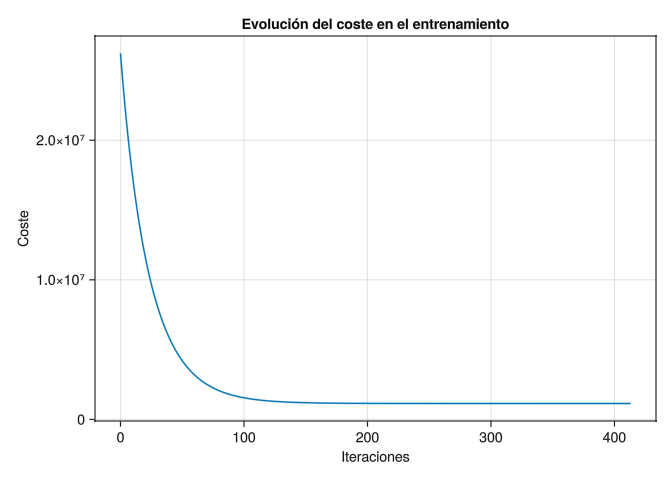

In [20]:
# Dibujamos el coste en cada iteración.
fig3 = Figure()
ax3 = Axis(fig3[1, 1], title = "Evolución del coste en el entrenamiento", xlabel = "Iteraciones", ylabel = "Coste")
lines!(ax3, 0:iteraciones, costes)
fig3

In [21]:
# Mostramos los pesos y el término independiente del modelo.
println("Pesos: ", modelo.weight, ", Término independiente: ", modelo.bias)

Pesos: Float32[536.325 97.91486 504.9331 392.71478 164.30511 123.32048 179.2231 187.51067 411.07886 257.39856 279.6773 10.985558], Término independiente: Float32[4765.594]


In [22]:
using CSV, DataFrames
df = CSV.read(download("https://aprendeconalf.es/aprendizaje-automatico-practicas-julia/datos/pingüinos.csv"), DataFrame, missingstring="NA")
first(df, 5)

Row,Especie,Isla,Longitud_pico,Profundidad_pico,Longitud_ala,Peso,Sexo
,String15,String15,Float64?,Float64?,Int64?,Int64?,String7?
1,Adelie,Torgersen,39.1,18.7,181,3750,macho
2,Adelie,Torgersen,39.5,17.4,186,3800,hembra
3,Adelie,Torgersen,40.3,18.0,195,3250,hembra
4,Adelie,Torgersen,missing,missing,missing,missing,missing
5,Adelie,Torgersen,36.7,19.3,193,3450,hembra


In [23]:
# Seleccionamos las columnas Longitud_pico, Profundidad_pico, Longitud_ala y Especie.
select!(df, [:Longitud_pico, :Profundidad_pico, :Longitud_ala, :Especie])
first(df, 5)

Row,Longitud_pico,Profundidad_pico,Longitud_ala,Especie
,Float64?,Float64?,Int64?,String15
1,39.1,18.7,181,Adelie
2,39.5,17.4,186,Adelie
3,40.3,18.0,195,Adelie
4,missing,missing,missing,Adelie
5,36.7,19.3,193,Adelie


In [24]:
describe(df, :nmissing)

Row,variable,nmissing
,Symbol,Int64
1,Longitud_pico,2
2,Profundidad_pico,2
3,Longitud_ala,2
4,Especie,0


In [25]:
dropmissing!(df)

Row,Longitud_pico,Profundidad_pico,Longitud_ala,Especie
,Float64,Float64,Int64,String15
1,39.1,18.7,181,Adelie
2,39.5,17.4,186,Adelie
3,40.3,18.0,195,Adelie
4,36.7,19.3,193,Adelie
5,39.3,20.6,190,Adelie
6,38.9,17.8,181,Adelie
7,39.2,19.6,195,Adelie
8,34.1,18.1,193,Adelie
9,42.0,20.2,190,Adelie


In [26]:
using MLJ
schema(df)

┌──────────────────┬────────────┬──────────┐
│ names            │ scitypes   │ types    │
├──────────────────┼────────────┼──────────┤
│ Longitud_pico    │ Continuous │ Float64  │
│ Profundidad_pico │ Continuous │ Float64  │
│ Longitud_ala     │ Count      │ Int64    │
│ Especie          │ Textual    │ String15 │
└──────────────────┴────────────┴──────────┘


In [27]:
# Convertimos la longitud del ala a tipo científico continuo.
coerce!(df, :Longitud_ala => Continuous)
# Convertimos la columna Especie a tipo Multiclass.
coerce!(df, Textual => Multiclass)
# Mostramos el nuevo esquema del data frame.
schema(df)

┌──────────────────┬───────────────┬────────────────────────────────────┐
│ names            │ scitypes      │ types                              │
├──────────────────┼───────────────┼────────────────────────────────────┤
│ Longitud_pico    │ Continuous    │ Float64                            │
│ Profundidad_pico │ Continuous    │ Float64                            │
│ Longitud_ala     │ Continuous    │ Float64                            │
│ Especie          │ Multiclass{3} │ CategoricalValue{String15, UInt32} │
└──────────────────┴───────────────┴────────────────────────────────────┘


In [28]:
y, X = unpack(df, ==(:Especie), name -> true);

In [29]:
using Flux, MLJFlux, Optimisers
# Cargamos el código que define las redes neuronales.
RedNeuronal = @load NeuralNetworkClassifier pkg = "MLJFlux"
# Creamos un modelo de red neuronal con los parámetros por defecto.
modelo = RedNeuronal(
    builder = MLJFlux.MLP(; hidden = (6,), σ = relu),
    optimiser=Optimisers.Adam(0.01),
    batch_size = 10,
    epochs = 0,
    # acceleration = CUDALibs()         # Para utilizar targetas gráficas GPU
    )
# Creamos una máquina de aprendizaje con el modelo y los datos.
mach = machine(modelo, X, y)

[ Info: For silent loading, specify `verbosity=0`. 


import MLJFlux ✔


untrained Machine; caches model-specific representations of data
  model: NeuralNetworkClassifier(builder = MLP(hidden = (6,), …), …)
  args: 
    1:	Source @444 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @566 ⏎ AbstractVector{Multiclass{3}}


In [30]:
# Dividimos el conjunto de datos en un conjunto de entrenamiento y otro de prueba.
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123)

([279, 255, 57, 6, 34, 267, 165, 35, 148, 56  …  320, 19, 85, 89, 284, 44, 169, 182, 98, 66], [236, 304, 118, 198, 80, 297, 257, 117, 67, 65  …  9, 329, 73, 121, 309, 54, 299, 71, 265, 127])

In [31]:
# Entrenamos el modelo con el conjunto de entrenamiento.
fit!(mach, rows = train)
# Predecimos las probabilidades de cada ejemplo de pertenecer a cada clase.
ŷ = predict(mach, rows = test)

[ Info: Training machine(NeuralNetworkClassifier(builder = MLP(hidden = (6,), …), …), …).
[ Info: MLJFlux: converting input data to Float32


103-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{3}, String15, UInt32, Float32}:
 UnivariateFinite{Multiclass{3}}(Adelie=>4.72e-10, Chinstrap=>2.34e-32, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>1.43e-10, Chinstrap=>4.9999998e-33, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>6.27e-8, Chinstrap=>2.28e-27, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>4.22e-10, Chinstrap=>2.7e-32, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>9.68e-8, Chinstrap=>4.53e-27, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>4.3e-9, Chinstrap=>4.24e-29, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>3.5e-10, Chinstrap=>6.45e-33, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>5.07e-8, Chinstrap=>1.9e-28, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>1.5e-8, Chinstrap=>2.0099999e-28, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>8.44e-9, Chinstrap=>4.57e-29, Gentoo=>1.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>2.71e-1

In [32]:
# Obtenemos la clase más probable.
mode.(ŷ)

103-element CategoricalArrays.CategoricalArray{String15,1,UInt32}:
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 ⋮
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")
 String15("Gentoo")

In [33]:
# Calculamos la matriz de confusión.
cm = confusion_matrix(y[test], mode.(ŷ))

          ┌─────────────────────────────┐
          │        Ground Truth         │
┌─────────┼─────────┬─────────┬─────────┤
│Predicted│ Adelie  │Chinstrap│ Gentoo  │
├─────────┼─────────┼─────────┼─────────┤
│ Adelie  │    0    │    0    │   45    │
├─────────┼─────────┼─────────┼─────────┤
│Chinstrap│    0    │    0    │   21    │
├─────────┼─────────┼─────────┼─────────┤
│ Gentoo  │    0    │    0    │   37    │
└─────────┴─────────┴─────────┴─────────┘


In [34]:
# Calculamos la precisión del modelo.
precision = sum(mode.(ŷ) .== y[test]) / length(test)
# O directamente usando la función accuracy
accuracy(mode.(ŷ), y[test])
println("Precisión del modelo: ", precision)
# Calculamos la entropía cruzada.
println("Entropía cruzada: ", cross_entropy(ŷ, y[test]))

Precisión del modelo: 0.3592233009708738


Entropía cruzada: 

14.96195555472543


In [35]:
# Definimos el número de épocas de entrenamiento.
modelo.epochs = 100
# Actualizamos la máquina de aprendizaje con el nuevo modelo.
mach = machine(modelo, X, y)
# Entrenamos el modelo con el conjunto de entrenamiento y evaluamos el modelo.
evaluate!(mach, resampling = Holdout(fraction_train = 0.7, rng = 123), measure = [accuracy, cross_entropy])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ Accuracy()           │ predict_mode │ 0.359       │
│ B │ LogLoss(             │ predict      │ 23.1        │
│   │   tol = 2.22045e-16) │              │             │
└───┴──────────────────────┴──────────────┴─────────────┘


In [36]:
# Definimos la transformación de estandarización.
estandarizacion = Standardizer()
# Definimos de nuevo la red neuronal.
red = RedNeuronal(
    builder = MLJFlux.MLP(; hidden = (6,), σ = relu),
    optimiser = Optimisers.Adam(0.01),
    batch_size = 10,
    epochs = 1
    )
# Definimos el modelo mediante un flujo que aplique primero la estandarización y luego la red neuronal.
modelo = estandarizacion  |> red
# Creamos una máquina de aprendizaje con el modelo y los datos.
mach = machine(modelo, X, y)
# Entrenamos el modelo con el conjunto de entrenamiento y evaluamos el modelo.
evaluate!(mach, resampling = Holdout(fraction_train = 0.7, rng = 123), measure = [accuracy, cross_entropy])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ Accuracy()           │ predict_mode │ 0.786       │
│ B │ LogLoss(             │ predict      │ 0.662       │
│   │   tol = 2.22045e-16) │              │             │
└───┴──────────────────────┴──────────────┴─────────────┘


In [37]:
# Definimos el número de épocas de entrenamiento.
red.epochs = 100
# Actualizamos la máquina de aprendizaje con el nuevo modelo.
evaluate!(mach, resampling = Holdout(fraction_train = 0.7, rng = 123), measure = [accuracy, cross_entropy])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ Accuracy()           │ predict_mode │ 0.99        │
│ B │ LogLoss(             │ predict      │ 0.0577      │
│   │   tol = 2.22045e-16) │              │             │
└───┴──────────────────────┴──────────────┴─────────────┘


In [38]:
evaluate!(mach, resampling = CV(nfolds = 10), measure = [accuracy, cross_entropy])

Evaluating over 10 folds:  20%[=====>                   ]  ETA: 0:00:01

Evaluating over 10 folds:  70%[=================>       ]  ETA: 0:00:00

Evaluating over 10 folds:  90%[======================>  ]  ETA: 0:00:00

Evaluating over 10 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ Accuracy()           │ predict_mode │ 0.985       │
│ B │ LogLoss(             │ predict      │ 0.0712      │
│   │   tol = 2.22045e-16) │              │             │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬───────────────────────────────────────────────────────────────────────────
│   │ per_fold                                                                 ⋯
├───┼───────────────────────────────────────────────────────────────────────────
│ A │ [1.0, 1.0, 0.941, 1.0, 1.0, 1.0, 1.0, 1.0, 0.971, 0.941]                 ⋯
│ B │ [0.00305, 0.00192, 0.287, 0.0255, 0.00442, 0.00154, 2.

In [39]:
# Definimos un rango de tasas de aprendizaje.
r = range(modelo, :(neural_network_classifier.epochs), lower=1, upper=100, scale=:log)
# Obtenemos las precisiones para cada número de etapas.
_, _, etapas, entropia = learning_curve(mach, range = r, resampling = CV(nfolds = 10), measure = cross_entropy)
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], title = "Precisión del modelo con distintas etapas de entrenamiento", xlabel = "Etapas", ylabel = "Precisión")
lines!(ax, etapas, entropia)
display(fig)
# Obtenemos el número de etapas con la mejor precisión.
etapas_optimas = etapas[argmin(entropia)]
println("Número de etapas óptimas: ", etapas_optimas)

[ Info: Training machine(ProbabilisticTunedModel(model = ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …), …).
[ Info: Attempting to evaluate 24 models.


Evaluating over 24 metamodels:   8%[==>                      ]  ETA: 0:00:10

Evaluating over 24 metamodels:  12%[===>                     ]  ETA: 0:00:06

Evaluating over 24 metamodels:  17%[====>                    ]  ETA: 0:00:05

Evaluating over 24 metamodels:  21%[=====>                   ]  ETA: 0:00:04

Evaluating over 24 metamodels:  25%[======>                  ]  ETA: 0:00:03

Evaluating over 24 metamodels:  29%[=======>                 ]  ETA: 0:00:03

Evaluating over 24 metamodels:  33%[========>                ]  ETA: 0:00:02

Evaluating over 24 metamodels:  38%[=========>               ]  ETA: 0:00:02

Evaluating over 24 metamodels:  42%[==========>              ]  ETA: 0:00:02

Evaluating over 24 metamodels:  46%[===========>             ]  ETA: 0:00:02

Evaluating over 24 metamodels:  50%[============>            ]  ETA: 0:00:01

Evaluating over 24 metamodels:  54%[=============>           ]  ETA: 0:00:01

Evaluating over 24 metamodels:  58%[==============>          ]  ETA: 0:00:01

Evaluating over 24 metamodels:  62%[===============>         ]  ETA: 0:00:01

Evaluating over 24 metamodels:  67%[================>        ]  ETA: 0:00:01

Evaluating over 24 metamodels:  71%[=================>       ]  ETA: 0:00:01

Evaluating over 24 metamodels:  75%[==================>      ]  ETA: 0:00:01

Evaluating over 24 metamodels:  79%[===================>     ]  ETA: 0:00:01

Evaluating over 24 metamodels:  83%[====================>    ]  ETA: 0:00:01

Evaluating over 24 metamodels:  88%[=====================>   ]  ETA: 0:00:00

Evaluating over 24 metamodels:  92%[======================>  ]  ETA: 0:00:00

Evaluating over 24 metamodels:  96%[=======================> ]  ETA: 0:00:00

Evaluating over 24 metamodels: 100%[=========================] Time: 0:00:04


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/ux0Te/src/scenes.jl:238


Número de etapas óptimas: 39


In [40]:
# Definimos el número de épocas de entrenamiento.
red.epochs = etapas_optimas
# Entrenamos el modelo con todo el conjunto de ejemplos.
fit!(mach)
# Predecimos la especie de los 5 primeros pingüinos del conjunto de ejemplos.
predict_mode(mach, X[1:5, :])

[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).


[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:neural_network_classifier, …).
[ Info: MLJFlux: converting input data to Float32
Optimising neural net:   5%[=>                       ]  ETA: 0:00:00

Optimising neural net:   8%[=>                       ]  ETA: 0:00:00

Optimising neural net:  10%[==>                      ]  ETA: 0:00:00

Optimising neural net:  12%[===>                     ]  ETA: 0:00:00

Optimising neural net:  15%[===>                     ]  ETA: 0:00:00

Optimising neural net:  18%[====>                    ]  ETA: 0:00:00

Optimising neural net:  20%[=====>                   ]  ETA: 0:00:00

Optimising neural net:  22%[=====>                   ]  ETA: 0:00:00

Optimising neural net:  25%[======>                  ]  ETA: 0:00:00

Optimising neural net:  28%[======>                  ]  ETA: 0:00:00

Optimising neural net:  30%[=======>                 ]  ETA: 0:00:00

Optimising neural net:  32%[========>                ]  ETA: 0:00:00

Optimising neural net:  35%[========>                ]  ETA: 0:00:00

Optimising neural net:  38%[=========>               ]  ETA: 0:00:00

Optimising neural net:  40%[==========>              ]  ETA: 0:00:00

Optimising neural net:  42%[==========>              ]  ETA: 0:00:00

Optimising neural net:  45%[===========>             ]  ETA: 0:00:00

Optimising neural net:  48%[===========>             ]  ETA: 0:00:00

Optimising neural net:  50%[============>            ]  ETA: 0:00:00

Optimising neural net:  52%[=============>           ]  ETA: 0:00:00

Optimising neural net:  55%[=============>           ]  ETA: 0:00:00

Optimising neural net:  58%[==============>          ]  ETA: 0:00:00

Optimising neural net:  60%[===============>         ]  ETA: 0:00:00

Optimising neural net:  62%[===============>         ]  ETA: 0:00:00

Optimising neural net:  65%[================>        ]  ETA: 0:00:00

Optimising neural net:  68%[================>        ]  ETA: 0:00:00

Optimising neural net:  70%[=================>       ]  ETA: 0:00:00

Optimising neural net:  72%[==================>      ]  ETA: 0:00:00

Optimising neural net:  75%[==================>      ]  ETA: 0:00:00

Optimising neural net:  78%[===================>     ]  ETA: 0:00:00

Optimising neural net:  80%[====================>    ]  ETA: 0:00:00

Optimising neural net:  82%[====================>    ]  ETA: 0:00:00

Optimising neural net:  85%[=====================>   ]  ETA: 0:00:00

Optimising neural net:  88%[=====================>   ]  ETA: 0:00:00

Optimising neural net:  90%[======================>  ]  ETA: 0:00:00

Optimising neural net:  92%[=======================> ]  ETA: 0:00:00

Optimising neural net:  95%[=======================> ]  ETA: 0:00:00

Optimising neural net:  98%[========================>]  ETA: 0:00:00

Optimising neural net: 100%[=========================] Time: 0:00:00


5-element CategoricalArrays.CategoricalArray{String15,1,UInt32}:
 String15("Adelie")
 String15("Adelie")
 String15("Adelie")
 String15("Adelie")
 String15("Adelie")